# CGAN(Conditional GAN)

$$L_D^{CGAN} = E[log(D(x,c))] + E[log(1 - D(G(z), c))]$$

$$L_G^{CGAN} = E[log(D(G(z),c))]$$

# GAN(Generative Adverserial Network)

$$L_D^{GAN} = E[log(D(x))] + E[log(1 - D(G(z))]$$

$$L_G^{GAN} = E[log(D(G(z)))]$$

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable, grad
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import gzip
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Setting Hyperparameters & dir

In [2]:
num_epochs = 30
learning_rate = 0.0002
batch_size = 64
z_dim = 62
y_dim = 10
sample_num = 100 # 50일때는 작동X
beta1 = 0.5
beta2 = 0.999

result_dir = './save_results/MNIST/CGAN'
model_dir = './save_models/MNIST/CGAN'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 3. Load dataset

In [3]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)
    
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

In [4]:
data_X, data_Y = load_mnist("MNIST")

print(data_X.size())
print(data_Y.size())
print(data_X.__getitem__(11).size())

torch.Size([70000, 1, 28, 28])
torch.Size([70000, 10])
torch.Size([1, 28, 28])


## 4. Build Models
### 4.1 Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim + 10
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

### 4.2 Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim + 10 # Label의 갯수를 더해줌
        self.output_dim = output_dim
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid()
        )
            
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)
        return x

## util

In [7]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['d_loss']))

    y1 = hist['d_loss']
    y2 = hist['g_loss']

    plt.plot(x, y1, label='d_loss')
    plt.plot(x, y2, label='g_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

## 5. Models & Optimizers
- BCE

In [8]:
G = Generator(28, 28, z_dim, 1)
D = Discriminator(28, 28, 1, 1)
G.initialize_weights()
D.initialize_weights()

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))

BCE_loss = nn.BCELoss()

# fix noise & condition
sample_z = torch.zeros((sample_num, z_dim)) # sample_num <-> batch_size
for i in range(10):
    sample_z[i*y_dim] = torch.rand(1, z_dim)
    for j in range(1, y_dim):
        sample_z[i*y_dim + j] = sample_z[i*y_dim]

temp = torch.zeros((10, 1))
for i in range(y_dim):
    temp[i, 0] = i
    
temp_y = torch.zeros((sample_num, 1))
for i in range(10):
    temp_y[i*y_dim:(i+1)*y_dim] = temp
    
sample_y = torch.zeros(sample_num, y_dim)
sample_y.scatter_(1, temp_y.type(torch.LongTensor), 1)

if USE_CUDA:
    G = G.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda() # 100 x 62 (sample_num x z_dim)
    sample_y = sample_y.cuda() # 100 x 10 (sample_num x label_size), identity maxtrix 

## 6. Load models

In [9]:
try:
    G.load_state_dict(torch.load(model_dir + '/cgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/cgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 7. Train

$$L_D^{CGAN} = E[log(D(x,c))] + E[log(1 - D(G(z), c))]$$

$$L_G^{CGAN} = E[log(D(G(z),c))]$$

In [10]:
train_hist = {}
train_hist['d_loss'] = []
train_hist['g_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

In [11]:
real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

if USE_CUDA:
    real_labels = real_labels.cuda()
    fake_labels = fake_labels.cuda()
    
fill = torch.zeros([10, 10, data_X.size()[2], data_X.size()[3]]) # 10 x 10 x 28 x 28
for i in range(10):
    fill[i, i, :, :] = 1

In [12]:
D.train()
print('training start!!')
start_time = time.time()

for epoch in range(1, num_epochs + 1):
#for epoch in range(1):
    G.train()
    epoch_start_time = time.time()
    
    for iter in range(len(data_X) // batch_size):
        images = data_X[iter*batch_size:(iter+1)*batch_size]
        y_vec = data_Y[iter*batch_size:(iter+1)*batch_size] # 64, 10
        
        z = torch.rand((batch_size, z_dim))
        y_fill = fill[torch.max(y_vec, 1)[1].squeeze()] # 라벨에 해당하는 인덱스의 값
        
        if USE_CUDA:
            images = images.cuda()
            z = z.cuda()
            y_vec = y_vec.cuda()
            y_fill = y_fill.cuda()
        
        #============= Train the discriminator =============#
        # update D network
        d_optimizer.zero_grad()
        
        d_real = D(images, y_fill)
        d_loss_real = BCE_loss(d_real, real_labels)
            
        fake_images = G(z, y_vec)
        d_fake = D(fake_images, y_fill)
        d_loss_fake = BCE_loss(d_fake, fake_labels)
            
        d_loss = d_loss_real + d_loss_fake
        train_hist['d_loss'].append(d_loss.item())
        
        d_loss.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # update G network
        g_optimizer.zero_grad()

        fake_images = G(z, y_vec)
        d_fake = D(fake_images, y_fill)
        g_loss = BCE_loss(d_fake, real_labels)
        train_hist['g_loss'].append(g_loss.item())

        g_loss.backward()
        g_optimizer.step()

        if ((iter + 1) % 100) == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                  %(epoch, num_epochs, (iter + 1), len(data_X) // batch_size, d_loss.item(), g_loss.item()))
            
    train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
    
    # Save
    G.eval()

    # Save sample images
    samples = G(sample_z, sample_y)
    generated_sample = samples.view(100, 1, 28, 28)
    save_image(generated_sample.data, result_dir + '/generated_images-%d.png'%(epoch + 1))
    
train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))

torch.save(G.state_dict(), model_dir + '/cgan_generator.pkl')
torch.save(D.state_dict(), model_dir + '/cgan_discriminator.pkl')

loss_plot(train_hist, result_dir, 'CGAN')

training start!!
Epoch [1/30], Step [100/1093], D_loss: 0.7414, G_loss: 1.2815
Epoch [1/30], Step [200/1093], D_loss: 0.7400, G_loss: 1.3150
Epoch [1/30], Step [300/1093], D_loss: 0.7997, G_loss: 1.2986
Epoch [1/30], Step [400/1093], D_loss: 0.8883, G_loss: 0.9331
Epoch [1/30], Step [500/1093], D_loss: 0.8342, G_loss: 1.5748
Epoch [1/30], Step [600/1093], D_loss: 0.9304, G_loss: 1.0079
Epoch [1/30], Step [700/1093], D_loss: 1.1827, G_loss: 0.9263
Epoch [1/30], Step [800/1093], D_loss: 1.1364, G_loss: 1.0783
Epoch [1/30], Step [900/1093], D_loss: 1.2855, G_loss: 1.0008
Epoch [1/30], Step [1000/1093], D_loss: 1.2359, G_loss: 0.8441
Epoch [2/30], Step [100/1093], D_loss: 1.3050, G_loss: 0.8768
Epoch [2/30], Step [200/1093], D_loss: 1.3155, G_loss: 0.8616
Epoch [2/30], Step [300/1093], D_loss: 1.3546, G_loss: 0.7909
Epoch [2/30], Step [400/1093], D_loss: 1.3389, G_loss: 0.7617
Epoch [2/30], Step [500/1093], D_loss: 1.3824, G_loss: 0.7468
Epoch [2/30], Step [600/1093], D_loss: 1.3592, G_los

Epoch [14/30], Step [200/1093], D_loss: 1.2578, G_loss: 0.8641
Epoch [14/30], Step [300/1093], D_loss: 1.3047, G_loss: 0.8648
Epoch [14/30], Step [400/1093], D_loss: 1.3223, G_loss: 0.8514
Epoch [14/30], Step [500/1093], D_loss: 1.2707, G_loss: 0.8877
Epoch [14/30], Step [600/1093], D_loss: 1.2694, G_loss: 0.8794
Epoch [14/30], Step [700/1093], D_loss: 1.2896, G_loss: 0.8610
Epoch [14/30], Step [800/1093], D_loss: 1.2268, G_loss: 0.9043
Epoch [14/30], Step [900/1093], D_loss: 1.2199, G_loss: 0.9149
Epoch [14/30], Step [1000/1093], D_loss: 1.2225, G_loss: 0.9334
Epoch [15/30], Step [100/1093], D_loss: 1.2482, G_loss: 0.9242
Epoch [15/30], Step [200/1093], D_loss: 1.2529, G_loss: 0.9109
Epoch [15/30], Step [300/1093], D_loss: 1.2122, G_loss: 0.9767
Epoch [15/30], Step [400/1093], D_loss: 1.2422, G_loss: 0.8765
Epoch [15/30], Step [500/1093], D_loss: 1.2552, G_loss: 0.8739
Epoch [15/30], Step [600/1093], D_loss: 1.2213, G_loss: 0.9332
Epoch [15/30], Step [700/1093], D_loss: 1.2221, G_loss

Epoch [27/30], Step [200/1093], D_loss: 0.8104, G_loss: 1.7663
Epoch [27/30], Step [300/1093], D_loss: 0.7595, G_loss: 1.5415
Epoch [27/30], Step [400/1093], D_loss: 0.7096, G_loss: 2.2298
Epoch [27/30], Step [500/1093], D_loss: 0.8776, G_loss: 1.4481
Epoch [27/30], Step [600/1093], D_loss: 0.6439, G_loss: 1.6830
Epoch [27/30], Step [700/1093], D_loss: 0.8592, G_loss: 1.6344
Epoch [27/30], Step [800/1093], D_loss: 0.7610, G_loss: 1.5577
Epoch [27/30], Step [900/1093], D_loss: 0.6567, G_loss: 1.6175
Epoch [27/30], Step [1000/1093], D_loss: 0.8842, G_loss: 2.4171
Epoch [28/30], Step [100/1093], D_loss: 0.9711, G_loss: 1.1687
Epoch [28/30], Step [200/1093], D_loss: 0.7817, G_loss: 1.7846
Epoch [28/30], Step [300/1093], D_loss: 1.0523, G_loss: 1.7298
Epoch [28/30], Step [400/1093], D_loss: 0.7125, G_loss: 1.5230
Epoch [28/30], Step [500/1093], D_loss: 0.7893, G_loss: 1.2228
Epoch [28/30], Step [600/1093], D_loss: 0.7184, G_loss: 2.0961
Epoch [28/30], Step [700/1093], D_loss: 0.9869, G_loss

## 8. Display generated data

In [13]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)


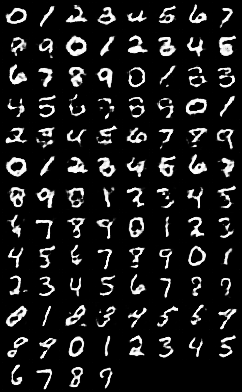

In [14]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## 9. Use model to generate new sample

In [15]:
try:
    G.load_state_dict(torch.load(model_dir + '/cgan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/cgan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



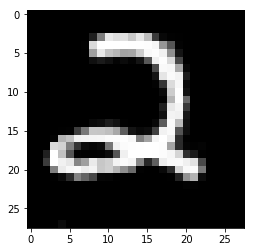

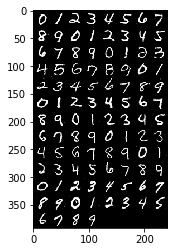

In [16]:
z = torch.zeros((sample_num, z_dim)) # sample_num <-> batch_size
for i in range(10):
    z[i*y_dim] = torch.rand(1, z_dim)
    for j in range(1, y_dim):
        z[i*y_dim + j] = sample_z[i*y_dim]

temp = torch.zeros((10, 1))
for i in range(y_dim):
    temp[i, 0] = i
    
temp_y = torch.zeros((sample_num, 1))
for i in range(10):
    temp_y[i*y_dim:(i+1)*y_dim] = temp
    
y = torch.zeros(sample_num, y_dim)
y.scatter_(1, temp_y.type(torch.LongTensor), 1)

if USE_CUDA:
    z = z.cuda()
    y = y.cuda()

G.eval()
fake_images = G(z, y)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(sample_num,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()